In [1]:
using DifferentialEquations
using LinearAlgebra
using Plots
using DataInterpolations
using Symbolics
using Symbolics: derivative

In [2]:
function mprod(x)
    Re = I(2)  
    Im = [0 -1;
           1 0]   
    M = kron(Re,real(x)) + kron(Im,imag(x));
    return M   
end

function inprod(x)
    a = x[1:n]
    b = x[(n+1):(2*n)]
    P = [a*a'+b*b' -(a*b'+b*a');
         a*b'+b*a' a*a'+b*b']
    return P
end

inprod (generic function with 1 method)

In [3]:
n = 3
m = 4

H0 = [-0.5 0 0;
         0 0 0;
      0 0 -0.5]

H1 = [0 -0.5 0;
      -0.5 0 0;
         0 0 0]

H2 = [0 -0.5im 0;
       0.5im 0 0;
           0 0 0]

H3 = [0 0 0;
   0 0 -0.5;
   0 -0.5 0]

H4 = [0 0 0;
 0 0 -0.5im;
  0 0.5im 0]

x0 = [1;0;0;0;0;0]
xf = [0;0;1;0;0;0]

Pf = I(2*n) - inprod(xf)

6×6 Matrix{Int64}:
 1  0  0  0  0  0
 0  1  0  0  0  0
 0  0  0  0  0  0
 0  0  0  1  0  0
 0  0  0  0  1  0
 0  0  0  0  0  0

In [4]:
@variables xx[1:(2*n)] uu[1:m] qq[1:(2*n)]

f(xx,uu) = collect(mprod(-1im*(H0 + uu[1]*H1 + uu[2]*H2 + uu[3]*H3 + uu[4]*H4))*xx)

ee = 0.1
Qe = inprod([0 1 0 0 0 0])
l(xx,uu) = 0.01/2*(uu[1]^2 + uu[2]^2 + uu[3]^2 + uu[4]^2) + ee*(xx[2]^2 + xx[5]^2)

# M(xx) = 1/2*xx'*Pf*xx

L(xx,uu,qq) = collect(l(xx,uu) + transpose(qq)*f(xx,uu))

function jacobian(dx, f, args...; inplace = false)
    f_sym = f(args...)
    fx_sym = cat(map(1:length(dx)) do i
        map(1:length(f_sym)) do j
            derivative(f_sym[j], dx[i])
        end
    end...; dims = ndims(f_sym)+1)

    return eval(build_function(fx_sym, args...)[inplace ? 2 : 1])
end

fx = jacobian(xx, f, xx, uu)
fu = jacobian(uu, f, xx, uu)


lx = jacobian(xx, l, xx, uu)
lu = jacobian(uu, l, xx, uu)

lxx = jacobian(xx, lx, xx, uu)
lxu = jacobian(uu, lx, xx, uu)
luu = jacobian(uu, lu, xx, uu)

Lx = jacobian(xx, L, xx, uu, qq)
Lu = jacobian(uu, L, xx, uu, qq)

Lxx = jacobian(xx, Lx, xx, uu, qq)
Lxu = jacobian(uu, Lx, xx, uu, qq)
Luu = jacobian(uu, Lu, xx, uu, qq)

# Mx = jacobian(xx, M, xx)
# Mxx = jacobian(xx, Mx, xx)

#28 (generic function with 1 method)

In [5]:
T = 5
tspan = (0.0,T)
tt = 0:0.005:T

mu = LinearInterpolation(0.05*ones(4, length(tt)), tt)

dal(al,_,t) = f(al,mu(t))
al0 = xf
al = solve(ODEProblem(dal,al0,tspan))

Pr_terminal(al) = I(2*n) - inprod(al)
Ar(t) = fx(al(t),mu(t))
Br(t) = fu(al(t),mu(t))
Qr(t) = I(2*n) - inprod(al(t))
Rr(t) = 1

Kr(Pr,Rr,Br)= Rr\(Br'*Pr)
Kr(t) = Kr(Pr(t),Rr(t),Br(t))

dPr(Pr,_,t) = Ar(T-t)'*Pr + Pr*Ar(T-t) - Kr(Pr,Rr(T-t),Br(T-t))'*Rr(T-t)*Kr(Pr,Rr(T-t),Br(T-t)) + Qr(T-t)
Pr(t) = Pr_back(T-t)

Pr (generic function with 1 method)

In [6]:
u(x,Kr,al,mu) = mu - (Kr*(x - al))
u(t) = u(x(t),Kr(t),al(t),mu(t))
    
dx(x,_,t) = f(x,u(x,Kr(Pr(t),Rr(t),Br(t)),al(t),mu(t)))

dJ(_,_,t) = 0.01/2*u(t)'*u(t) + ee*(x(t)'*Qe*x(t))

P_terminal = Pf

A(t) = fx(x(t),u(t))
B(t) = fu(x(t),u(t))
a(t) = lx(x(t),u(t))
b(t) = lu(x(t),u(t))
Q(t) = lxx(x(t),u(t))
S(t) = lxu(x(t),u(t))
R(t) = luu(x(t),u(t))

dq(q,_,t) = (A(T-t) - B(T-t)*Kr(T-t))'*q + a(T-t) - Kr(T-t)'*b(T-t)
q(t) = q_back(T-t)
# qT(al) = Mx(al)' 


Qo(t) = Lxx(x(t),u(t),q(t))
So(t) = Lxu(x(t),u(t),q(t))
Ro(t) = Luu(x(t),u(t),q(t))

Ro (generic function with 1 method)

In [7]:
# GD
Ko(P,R,S,B)= R\(S' + B'*P)

Ko(t) = Ko(P(t),R(t),S(t),B(t))

dP(P,_,t) = A(T-t)'*P + P*A(T-t) - Ko(P,R(T-t),S(T-t),B(T-t))'*R(T-t)*Ko(P,R(T-t),S(T-t),B(T-t)) + Q(T-t)
P(t)=P_back(T-t)

PT = Pf

dr(r,_,t) = (A(T-t) - B(T-t)*Ko(T-t))'*r + a(T-t) - Ko(T-t)'*b(T-t)
r(t)=r_back(T-t)

vo(R,B,r,b) = -R\(B'*r + b)

vo(t) = vo(R(t),B(t),r(t),b(t))

v(z,Ko,vo) = (-Ko*z) + vec(vo)

v(t) = v(z(t),Ko(t),vo(t))

dz(z,_,t) = A(t)*z + B(t)*v(z,Ko(t),vo(t))

z0 = 0*x0

dy1(_,_,t) = a(t)'*z(t) + b(t)'*v(t)

dy2(_,_,t) = z(t)'*Qo(t)*z(t) + (2*z(t)'*So(t)*v(t))'[1] + v(t)'*Ro(t)*v(t)

gamma = 1

al1(x,z)    = x + gamma*z
mu1(u,v)    = u + gamma*v
u1(x1,Kr,al1,mu1) = mu1 - (Kr*(x1 - al1))

al1(t) = x(t) + gamma*z(t)
mu1(t) = mu1(u(t),v(t))
u1(t) = u1(x1(t),Kr(t),al1(t),mu1(t));


dx1(x1,_,t) = f(x1,u1(x1,Kr(t),al1(x(t),z(t)),mu1(u(t),v(t))))
dJ1(_,_,t) = 0.01/2*u1(t)'*u1(t) + ee*(x1(t)'*Qe*x1(t))

dJ1 (generic function with 1 method)

In [8]:
# Newt
Ko2(P2,Ro,So,B)= Ro\(So' + B'*P2)

Ko2(t) = Ko2(P2(t),Ro(t),So(t),B(t))

dP2(P2,_,t) = A(T-t)'*P2 + P2*A(T-t) - Ko2(P2,Ro(T-t),So(T-t),B(T-t))'*Ro(T-t)*Ko2(P2,Ro(T-t),So(T-t),B(T-t)) + Qo(T-t)
P2(t)=P2_back(T-t)

P2T = Pf

dr2(r2,_,t) = (A(T-t) - B(T-t)*Ko2(T-t))'*r2 + a(T-t) - Ko2(T-t)'*b(T-t)
r2(t)=r2_back(T-t)

vo2(Ro,B,r2,b) = -Ro\(B'*r2 + b)

vo2(t) = vo2(Ro(t),B(t),r2(t),b(t))

v2(z2,Ko2,vo2) = (-Ko2*z2) + vec(vo2)

v2(t) = v2(z2(t),Ko2(t),vo2(t))

dz2(z2,_,t) = A(t)*z2 + B(t)*v2(z2,Ko2(t),vo2(t))

z20 = 0*x0

dy12(_,_,t) = a(t)'*z2(t) + b(t)'*v2(t)

dy22(_,_,t) = z2(t)'*Qo(t)*z2(t) + (2*z2(t)'*So(t)*v2(t))'[1] + v2(t)'*Ro(t)*v2(t)

gamma = 1

al2(x,z2)    = x + gamma*z2
mu2(u,v2)    = u + gamma*v2
u2(x2,Kr,al2,mu2) = mu2 - Kr*(x2 - al2)

al2(t) = x(t) + gamma*z2(t)
mu2(t) = mu2(u(t),v2(t))
u2(t) = u2(x2(t),Kr(t),al2(t),mu2(t));


dx2(x2,_,t) = f(x2,u2(x2,Kr(t),al2(x(t),z2(t)),mu2(u(t),v2(t))))
dJ2(_,_,t) = 0.01/2*u2(t)'*u2(t) + ee*(x2(t)'*Qe*x2(t))

dJ2 (generic function with 1 method)

In [9]:
global Pr_back
global x
global J
global h
global q_back
global P_back
global P2_back
global r_back
global r2_back
global z
global z2
global y1
global y12
global y2
global y22
global Dh
global Dg2
global x1
global x2
global J1
global J2
global g
global tt
global utt
CostH = zeros(20)
CostG = zeros(20)
Descent = zeros(20)
Gam = zeros(20)
Method = zeros(20)

utt = zeros(4,length(tt))

for iter = 1:20

    Pr_back = solve(ODEProblem(dPr,Pr_terminal(al(T)),tspan))

    x = solve(ODEProblem(dx,x0,tspan))

    J = solve(ODEProblem(dJ,0,tspan))

    h = J(T) + 1/2*x(T)'*Pf*x(T)
    
    CostH[iter] = h

    q_back = solve(ODEProblem(dq,Pf*al(T),tspan))
        
    P2_back = solve(ODEProblem(dP2,P2T,tspan),maxiters = 1e3)
    
    if abs(P2_back.destats.maxeig) < 1e8
        
        r2_back = solve(ODEProblem(dr2,Pf*al(T),tspan))
        
        z2 = solve(ODEProblem(dz2,z20,tspan))
        
        y12 = solve(ODEProblem(dy12,0,tspan))
        
        y22 = solve(ODEProblem(dy22,0,tspan))
        
        Dh = y12(T) + (Pf*al(T))'*z2(T)
        Dg2 = y22(T) + z2(T)'*Pf*z2(T)
    
        Descent[iter] = -Dh
        
        if Descent[iter] < 1e-5
            break
        end
        
        Method[iter] = 2

        x2 = al
        J2 = J
        g = h
        gamma = 1

        for j = 1:10

            x2 = solve(ODEProblem(dx2,x0,tspan))

            J2 = solve(ODEProblem(dJ2,0,tspan))

            g = J2(T) + 1/2*x2(T)'*Pf*x2(T)
    
            if h-g >= -0.4*gamma*Dh
                Gam[iter] = gamma
                break
            else
                gamma = 0.7*gamma
            end
    
        end
    
        CostG[iter] = g

    
        for counter = 1:length(tt)
            utt[:,counter] = u2(tt[counter])
        end
    
        mu = LinearInterpolation(utt,tt)
        al = x2
        
    else 
        
        P_back = solve(ODEProblem(dP,PT,tspan))

        r_back = solve(ODEProblem(dr,Pf*al(T),tspan))

        z = solve(ODEProblem(dz,z0,tspan))

        y1 = solve(ODEProblem(dy1,0,tspan))

        y2 = solve(ODEProblem(dy2,0,tspan))

        Dh = y1(T) + (Pf*al(T))'*z(T)
        Dg2 = y2(T) + z(T)'*Pf*z(T)
    
        Descent[iter] = -Dh
        
        if Descent[iter] < 1e-5
            break
        end
        
        Method[iter] = 1

        x1 = al
        J1 = J
        g = h
        gamma = 1

        for j = 1:10

            x1 = solve(ODEProblem(dx1,x0,tspan))

            J1 = solve(ODEProblem(dJ1,0,tspan))

            g = J1(T) + 1/2*x1(T)'*Pf*x1(T)
    
            if h-g >= -0.4*gamma*Dh
                Gam[iter] = gamma
                break
            else
                gamma = 0.7*gamma
            end
    
        end
    
        CostG[iter] = g

    
        for counter = 1:length(tt)
            utt[:,counter] = u1(tt[counter])
        end
    
        mu = LinearInterpolation(utt,tt)
        al = x1
        
    end
    
end

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/jieqiushao/.julia/packages/SciMLBase/GW7GW/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/jieqiushao/.julia/packages/SciMLBase/GW7GW/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/jieqiushao/.julia/packages/SciMLBase/GW7GW/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/jieqiushao/.julia/packages/SciMLBase/GW7GW/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBa

In [10]:
Descent

20-element Vector{Float64}:
 0.042520421897843
 0.03296938383903247
 0.045870472142278344
 0.35452745488275583
 0.28522564201036316
 0.08530511398632226
 0.017443198061364507
 0.0018147148133009624
 0.0008201738066521554
 0.0004001880420739292
 0.00021675309130411296
 0.00010991065949271991
 7.895895144088329e-5
 5.4373708557490055e-5
 4.141632552991388e-5
 3.4381462016310174e-5
 3.289998299688871e-5
 2.1355531756046376e-5
 2.2644306512637498e-5
 2.98560465715838e-5

In [11]:
Method

20-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [12]:
Gam

20-element Vector{Float64}:
 0.0
 0.7
 1.0
 1.0
 0.7
 0.7
 1.0
 1.0
 1.0
 1.0
 0.7
 1.0
 0.7
 0.7
 0.48999999999999994
 1.0
 0.7
 1.0
 0.48999999999999994
 1.0

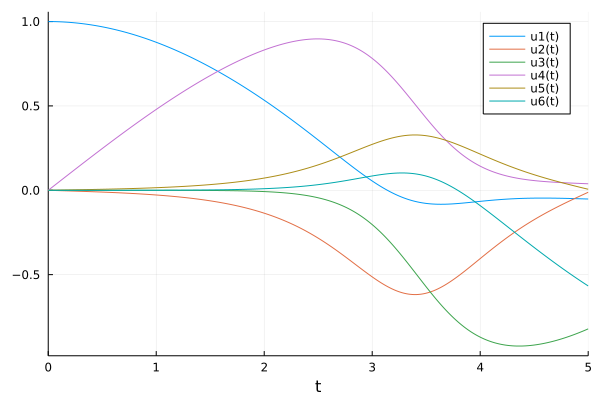

In [13]:
plot(al)

In [14]:
CostH

20-element Vector{Float64}:
 0.513446319815077
 0.5130680061906512
 0.5001397473733328
 0.3968449909553942
 0.2506314322452057
 0.16979305088357652
 0.13661066316759532
 0.12732706913822714
 0.12630888273990623
 0.12582782752605862
 0.12554950413689403
 0.12546260394115244
 0.12534674780618824
 0.12529418671872525
 0.12526844886064134
 0.12527515464535183
 0.1251999352471511
 0.12518054330780296
 0.12516118900532314
 0.1251488143324429

In [15]:
using MAT

file = matopen("Uopt.mat", "w")
write(file, "Uopt", utt)
close(file)